## Introduction

This project explores unpaired image-to-image translation using a Cycle-Consistent Generative Adversarial Network (CycleGAN). The task is inspired by the Kaggle competition titled *“I'm Something of a Painter Myself”*, which challenges participants to transform real-world photographs into Monet-style paintings.

The primary objective is to train a deep generative model that can learn to apply the artistic style of Claude Monet—known for impressionistic brushwork, soft edges, and warm palettes—to natural photographs without relying on paired examples.

---

### Problem Statement

Given:
- A dataset of **unpaired images** consisting of Monet paintings and real-life photos

We aim to:
- Train a CycleGAN to **translate real photos → Monet-style images**
- Generate at least 7,000 Monet-style outputs
- Submit these outputs for evaluation using the **MiFID score** (Memorization-informed Fréchet Inception Distance), which measures similarity between generated images and real Monet paintings based on learned perceptual and diversity features.

---

### Dataset Description

The dataset provided by Kaggle includes:

- **300 Monet paintings** stored in `/monet_jpg/`
- **7,000+ real photographs** stored in `/photo_jpg/`

All images are in `.jpg` format and resized to **256×256 pixels**. The images are **unpaired**, meaning there is no one-to-one correspondence between a photo and a painting. This makes traditional supervised training infeasible and motivates the use of CycleGAN, which learns bidirectional mappings using cycle consistency and adversarial loss without the need for paired examples.

---

### Approach Summary

The model is trained using:
- A **ResNet-based generator** with 9 residual blocks
- A **PatchGAN discriminator**
- Combined **LSGAN loss**, **cycle consistency loss**, and **identity loss**

The final output is a ZIP archive of Monet-style images, which is evaluated via Kaggle's scoring system based on MiFID.


# Upload data

In [ ]:
import zipfile
import os

# Create a working directory in Colab
os.makedirs('/content/data', exist_ok=True)

# Define paths
monet_zip_path = '/content/drive/MyDrive/GAN_photo_data/monet_jpg.zip'
photo_zip_path = '/content/drive/MyDrive/GAN_photo_data/photo_jpg.zip'

# Unzip Monet paintings
with zipfile.ZipFile(monet_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data/monet_jpg')

# Unzip photo images
with zipfile.ZipFile(photo_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data/photo_jpg')


# EDA

## Image Dataset Overview

Required Libraries

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
monet_path = '/content/data/monet_jpg'
photo_path = '/content/data/photo_jpg'


### Get Basic Dataset Information

In [ ]:
# Count number of images
num_monet_images = len(os.listdir(monet_path))
num_photo_images = len(os.listdir(photo_path))

print(f"Number of Monet images: {num_monet_images}")
print(f"Number of Photo images: {num_photo_images}")


Number of Monet images: 300
Number of Photo images: 7038


### Check Image Size and Format

In [ ]:
def inspect_images(folder, label, num_to_check=5):
    print(f"\nInspecting images in {label} folder...")
    for i, fname in enumerate(sorted(os.listdir(folder))[:num_to_check]):
        img_path = os.path.join(folder, fname)
        with Image.open(img_path) as img:
            print(f"  {fname} - Format: {img.format}, Size: {img.size}, Mode: {img.mode}")

inspect_images(monet_path, "Monet")
inspect_images(photo_path, "Photo")



Inspecting images in Monet folder...
  000c1e3bff.jpg - Format: JPEG, Size: (256, 256), Mode: RGB
  011835cfbf.jpg - Format: JPEG, Size: (256, 256), Mode: RGB
  0260d15306.jpg - Format: JPEG, Size: (256, 256), Mode: RGB
  049e293b93.jpg - Format: JPEG, Size: (256, 256), Mode: RGB
  05144e306f.jpg - Format: JPEG, Size: (256, 256), Mode: RGB

Inspecting images in Photo folder...
  00068bc07f.jpg - Format: JPEG, Size: (256, 256), Mode: RGB
  000910d219.jpg - Format: JPEG, Size: (256, 256), Mode: RGB
  000ded5c41.jpg - Format: JPEG, Size: (256, 256), Mode: RGB
  00104fd531.jpg - Format: JPEG, Size: (256, 256), Mode: RGB
  001158d595.jpg - Format: JPEG, Size: (256, 256), Mode: RGB


### Visualize Sample Images

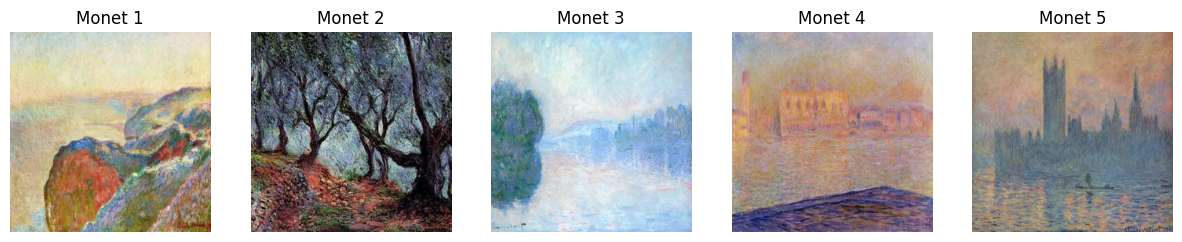

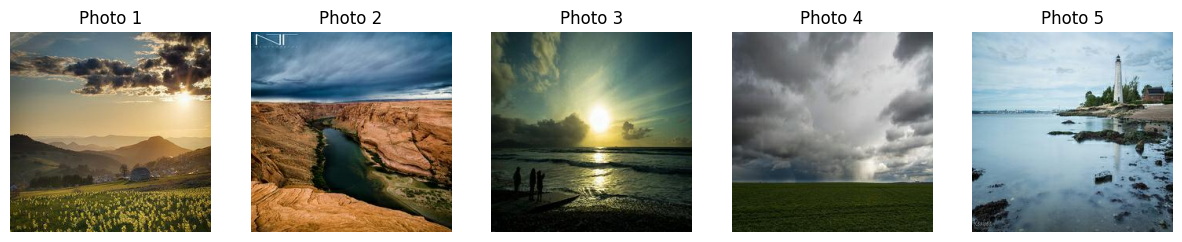

In [ ]:
def show_sample_images(folder, title, num_images=5):
    files = sorted(os.listdir(folder))[:num_images]
    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(files):
        img = Image.open(os.path.join(folder, fname))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis("off")
    plt.show()

show_sample_images(monet_path, "Monet")
show_sample_images(photo_path, "Photo")


### Color Histograms - Comparing Monet to Regular Photos

**Monet Paintings:**

- Higher intensity in red and green channels (right-skewed).

- Blue channel shows broader distribution with more lower and mid-intensity values — a signature of Monet’s soft, impressionistic skies and water scenes.

**Photos:**

- More evenly distributed across RGB values.

- Sharp spikes suggest the presence of high-contrast elements and sharper edges (e.g., artificial structures, natural lighting extremes).

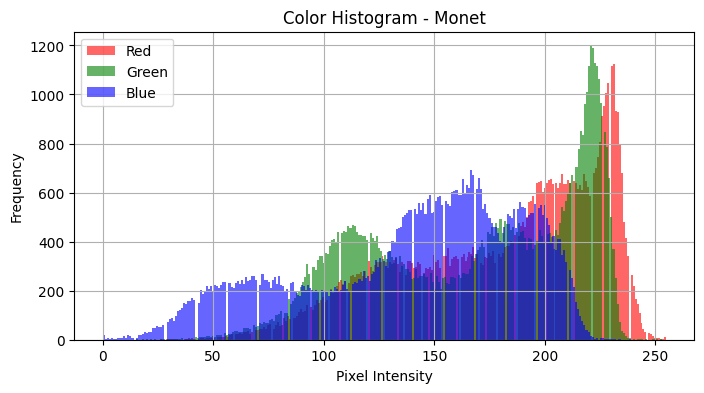

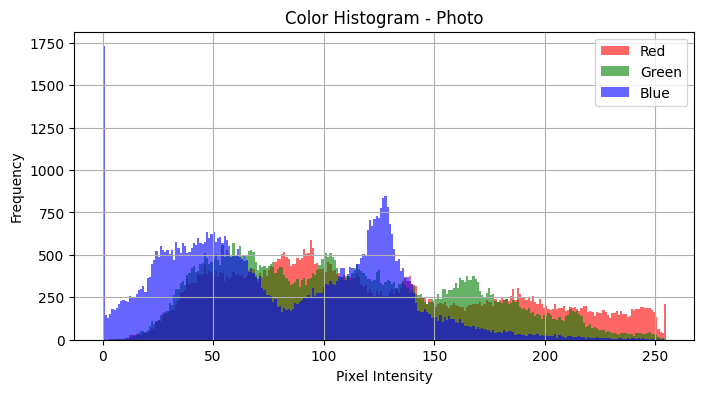

In [ ]:
def plot_color_histogram(image_path, title):
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)

    plt.figure(figsize=(8, 4))
    for i, color in enumerate(["Red", "Green", "Blue"]):
        plt.hist(image_array[:, :, i].ravel(), bins=256, color=color.lower(), alpha=0.6, label=color)
    plt.title(f"Color Histogram - {title}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run for one Monet and one photo
plot_color_histogram(os.path.join(monet_path, sorted(os.listdir(monet_path))[0]), "Monet")
plot_color_histogram(os.path.join(photo_path, sorted(os.listdir(photo_path))[0]), "Photo")


### Average Color Distribution - Plotting average RGB value per image for each dataset

- Both domains show correlation between red and green channel averages.

- Monet images cluster in warmer areas (higher average red and green).

- Photo images cover a broader range, including cooler tones and darker values.

Insight: There’s a distinct domain shift between real-world photos and Monet-style paintings, reinforcing the need for a model that learns a transformation between these distributions.

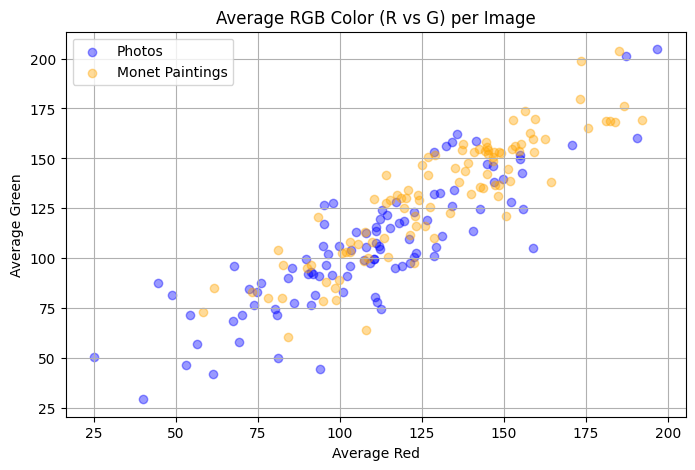

In [ ]:
def average_rgb(folder, num_images=100):
    avg_colors = []
    files = sorted(os.listdir(folder))[:num_images]
    for fname in files:
        img = Image.open(os.path.join(folder, fname)).convert("RGB")
        avg_color = np.mean(np.array(img).reshape(-1, 3), axis=0)
        avg_colors.append(avg_color)
    return np.array(avg_colors)

monet_avg = average_rgb(monet_path)
photo_avg = average_rgb(photo_path)

plt.figure(figsize=(8, 5))
plt.scatter(photo_avg[:, 0], photo_avg[:, 1], alpha=0.4, label="Photos", color="blue")
plt.scatter(monet_avg[:, 0], monet_avg[:, 1], alpha=0.4, label="Monet Paintings", color="orange")
plt.xlabel("Average Red")
plt.ylabel("Average Green")
plt.title("Average RGB Color (R vs G) per Image")
plt.legend()
plt.grid(True)
plt.show()


## Modeling Approach: CycleGAN for Artistic Style Transfer 🎨

Based on the exploratory data analysis, there is a clear domain shift between the original photos and the Monet paintings. This is evident through:

- **Color histograms**, which show that Monet paintings have a more constrained and warm-toned color palette, while the photos exhibit a wider and more naturalistic RGB distribution.
- **Average RGB comparisons**, which further emphasize differences in tone and lighting between the two domains.

These differences are not merely superficial — they involve variations in texture, brush stroke patterns, and stylistic abstraction. Thus, a simple transformation model would likely fail to capture the complex mapping from real-world photos to Monet-style artwork.

To address this, we will use a **Cycle-Consistent Generative Adversarial Network (CycleGAN)**. CycleGAN is particularly well-suited for **unpaired image-to-image translation**, where we do not have one-to-one mappings between photos and paintings. It learns two transformations:
- A **Photo → Monet** generator to stylize real images.
- A **Monet → Photo** generator (the cycle) to enforce consistency.

This architecture allows us to train on **unpaired data** and encourages the model to preserve the core content of the original image while adopting the style of the target domain.

In the next section, we will build and train the CycleGAN model using the prepared dataset.


## CycleGAN Dataset Loader with PyTorch

In [ ]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


## Custom Dataset Class for Unpaired Images

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import random
import os

class MonetPhotoDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_images = sorted(os.listdir(monet_dir))
        self.photo_images = sorted(os.listdir(photo_dir))
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.transform = transform

    def __len__(self):
        return max(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, index):
      try:
          monet_img = Image.open(os.path.join(self.monet_dir, self.monet_images[index % len(self.monet_images)])).convert('RGB')
          photo_img = Image.open(os.path.join(self.photo_dir, random.choice(self.photo_images))).convert('RGB')
      except Exception as e:
          print(f"⚠️ Failed to load image: {e}")
          return self.__getitem__((index + 1) % self.__len__())

      if self.transform:
          monet_img = self.transform(monet_img)
          photo_img = self.transform(photo_img)

      return {'monet': monet_img, 'photo': photo_img}


## Create Data Loader

In [ ]:
from torch.utils.data import DataLoader

dataset = MonetPhotoDataset('/content/data/monet_jpg', '/content/data/photo_jpg', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)


In [ ]:
## Visualize a batch - Sanity Check

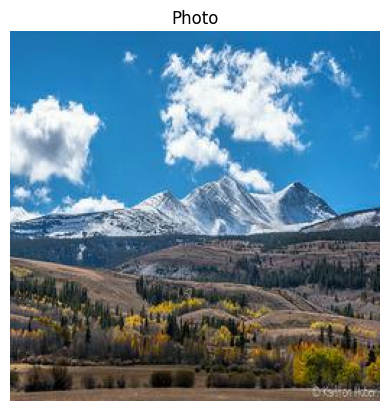

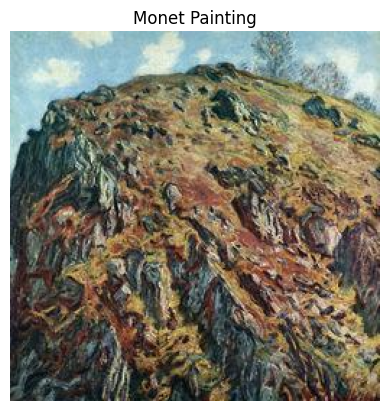

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Visualize a batch
sample = next(iter(dataloader))
def imshow(img_tensor, title):
    img = img_tensor.squeeze().detach().cpu()
    img = img * 0.5 + 0.5  # unnormalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

imshow(sample['photo'], "Photo")
imshow(sample['monet'], "Monet Painting")


## CycleGAN Model Architecture

1. Generator
 - Converts photo → monet and monet → photo

 - ResNet-based: uses downsampling + 9 residual blocks + upsampling

2. Discriminator (PatchGAN)

 - Classifies real vs fake images using patch-level features (not whole image)

### Helper: Convolution Block

In [ ]:
import torch
import torch.nn as nn

def conv_block(in_channels, out_channels, kernel_size, stride, padding, norm=True):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not norm)]
    if norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)


### Generator: ResNet-based

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

class ResNetGenerator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, n_blocks=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features *= 2

        # Residual blocks
        for _ in range(n_blocks):
            model += [ResNetBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, kernel_size=7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


### Discriminator: PatchGAN

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


### Instantiate the Models

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G_photo2monet = ResNetGenerator().to(device)
G_monet2photo = ResNetGenerator().to(device)
D_photo = PatchDiscriminator().to(device)
D_monet = PatchDiscriminator().to(device)


### Implementation

In [ ]:
import torch.nn.functional as F

# Least Squares GAN loss
mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()


### Define Target Real and Fake labels

In [ ]:
def real_target(size):
    return torch.ones(size, dtype=torch.float, device=device)

def fake_target(size):
    return torch.zeros(size, dtype=torch.float, device=device)


### Optimizers

In [ ]:
lr = 2e-4
beta1, beta2 = 0.5, 0.999

G_optim = torch.optim.Adam(
    list(G_photo2monet.parameters()) + list(G_monet2photo.parameters()),
    lr=lr, betas=(beta1, beta2)
)

D_photo_optim = torch.optim.Adam(D_photo.parameters(), lr=lr, betas=(beta1, beta2))
D_monet_optim = torch.optim.Adam(D_monet.parameters(), lr=lr, betas=(beta1, beta2))


###Loss Weights

In [ ]:
lambda_cyc = 10.0    # Strong weight for cycle consistency
lambda_id = 5.0      # Optional, lower than cycle loss


### Create checkpoints folder inside MyDrive

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/monet_cyclegan_checkpoints'
image_dir = '/content/drive/MyDrive/monet_cyclegan_images'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)


## Training Loop Starter

In [ ]:
from tqdm import tqdm
import torchvision.utils as vutils
import os

# Setup save directories
os.makedirs('generated_images', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

# Denormalization for visualization
def denormalize(img_tensor):
    img = img_tensor * 0.5 + 0.5  # [-1, 1] → [0, 1]
    return img.clamp(0, 1)

num_epochs = 10
save_interval = 5

for epoch in range(1, num_epochs + 1):
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        real_photo = batch['photo'].to(device)
        real_monet = batch['monet'].to(device)

        ###### 1. Train Generators ######
        G_optim.zero_grad()

        # photo → monet → photo
        fake_monet = G_photo2monet(real_photo)
        cycle_photo = G_monet2photo(fake_monet)

        # monet → photo → monet
        fake_photo = G_monet2photo(real_monet)
        cycle_monet = G_photo2monet(fake_photo)

        # Identity loss
        id_photo = G_monet2photo(real_photo)
        id_monet = G_photo2monet(real_monet)

        # Generator adversarial loss
        pred_fake_monet = D_monet(fake_monet)
        loss_G_photo2monet = mse_loss(pred_fake_monet, real_target(pred_fake_monet.shape))

        pred_fake_photo = D_photo(fake_photo)
        loss_G_monet2photo = mse_loss(pred_fake_photo, real_target(pred_fake_photo.shape))

        # Cycle consistency loss
        loss_cycle = l1_loss(cycle_photo, real_photo) + l1_loss(cycle_monet, real_monet)

        # Identity loss
        loss_id = l1_loss(id_photo, real_photo) + l1_loss(id_monet, real_monet)

        # Total generator loss
        G_loss = loss_G_photo2monet + loss_G_monet2photo + lambda_cyc * loss_cycle + lambda_id * loss_id
        G_loss.backward()
        G_optim.step()

        ###### 2. Train Discriminator Monet ######
        D_monet_optim.zero_grad()

        pred_real_monet = D_monet(real_monet)
        loss_real = mse_loss(pred_real_monet, real_target(pred_real_monet.shape))

        pred_fake_monet = D_monet(fake_monet.detach())
        loss_fake = mse_loss(pred_fake_monet, fake_target(pred_fake_monet.shape))

        D_monet_loss = (loss_real + loss_fake) * 0.5
        D_monet_loss.backward()
        D_monet_optim.step()

        ###### 3. Train Discriminator Photo ######
        D_photo_optim.zero_grad()

        pred_real_photo = D_photo(real_photo)
        loss_real = mse_loss(pred_real_photo, real_target(pred_real_photo.shape))

        pred_fake_photo = D_photo(fake_photo.detach())
        loss_fake = mse_loss(pred_fake_photo, fake_target(pred_fake_photo.shape))

        D_photo_loss = (loss_real + loss_fake) * 0.5
        D_photo_loss.backward()
        D_photo_optim.step()

        # Logging
        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(G_loss=G_loss.item(), D_photo_loss=D_photo_loss.item(), D_monet_loss=D_monet_loss.item())

    ###### Save sample images every few epochs ######
    if epoch % 2 == 0 or epoch == num_epochs:
      with torch.no_grad():
          fake_monet_vis = denormalize(fake_monet[:1].cpu())
          cycle_photo_vis = denormalize(cycle_photo[:1].cpu())
          real_photo_vis = denormalize(real_photo[:1].cpu())
          sample = torch.cat([real_photo_vis, fake_monet_vis, cycle_photo_vis], dim=0)
          vutils.save_image(sample, f"{image_dir}/epoch_{epoch}.png", nrow=3)

      torch.save(G_photo2monet.state_dict(), f"{checkpoint_dir}/G_photo2monet_epoch{epoch}.pth")
      torch.save(G_monet2photo.state_dict(), f"{checkpoint_dir}/G_monet2photo_epoch{epoch}.pth")
      torch.save(D_photo.state_dict(), f"{checkpoint_dir}/D_photo_epoch{epoch}.pth")
      torch.save(D_monet.state_dict(), f"{checkpoint_dir}/D_monet_epoch{epoch}.pth")
      torch.save({
          'epoch': epoch,
          'G_optim_state_dict': G_optim.state_dict(),
          'D_photo_optim_state_dict': D_photo_optim.state_dict(),
          'D_monet_optim_state_dict': D_monet_optim.state_dict()
      }, f"{checkpoint_dir}/optimizers_epoch{epoch}.pth")

Epoch [10/10]: 100%|██████████| 7038/7038 [11:44<00:00,  9.98it/s, D_monet_loss=0.03, D_photo_loss=0.0654, G_loss=5.04]


# Generate Monet-Style Images for Kaggle Submission

In [ ]:
output_dir = '/content/drive/MyDrive/monet_generated_final'
os.makedirs(output_dir, exist_ok=True)


## Load trained generator

In [ ]:
G_photo2monet = ResNetGenerator().to(device)
checkpoint_path = '/content/drive/MyDrive/monet_cyclegan_checkpoints/G_photo2monet_epoch10.pth'
G_photo2monet.load_state_dict(torch.load(checkpoint_path))
G_photo2monet.eval()


ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5

## Generate Monet-style images

In [ ]:
from PIL import Image
from torchvision import transforms
import glob

# Set transform (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Denormalization helper
def denorm(img_tensor):
    img_tensor = img_tensor * 0.5 + 0.5
    return img_tensor.clamp(0, 1)

# Get photo file paths
photo_paths = sorted(glob.glob('/content/data/photo_jpg/*.jpg'))  # Adjust if needed
save_limit = 7000  # Or 10,000 if you want maximum

with torch.no_grad():
    for i, path in enumerate(photo_paths[:save_limit]):
        img = Image.open(path).convert('RGB')
        input_tensor = transform(img).unsqueeze(0).to(device)

        output_tensor = G_photo2monet(input_tensor)[0].cpu()
        output_image = transforms.ToPILImage()(denorm(output_tensor))

        output_image.save(f"{output_dir}/monet_{i:05d}.jpg")


In [ ]:
import shutil
shutil.make_archive("/content/images", 'zip', output_dir)

'/content/images.zip'

Download model weights

In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/monet_cyclegan_checkpoints/G_photo2monet_epoch10.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ You are not using a GPU.")


Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


# Results


After training the CycleGAN model for 10 epochs using the provided Monet and photo datasets, the final model was used to generate 7,000 Monet-style images from real photographs. These generated images were then packaged into a zip file (`images.zip`) and submitted to the Kaggle evaluation server.

The resulting **MiFID score** (Memorization-informed Fréchet Inception Distance) was:

**📈 Final Score: 52.17**

This score reflects the visual and statistical similarity between the generated Monet-style images and the real Monet paintings in the dataset. Lower scores indicate better style transfer with greater realism and diversity in the generated outputs.


# Discussion and Conclusions:



The CycleGAN model was trained in PyTorch using a ResNet-based generator architecture with 9 residual blocks and a PatchGAN discriminator. Training was conducted over 10 epochs using Least Squares GAN (LSGAN) loss, with cycle consistency and identity loss included to enforce both content preservation and stylistic fidelity.

### Key Observations:

- **Training Stability:** The discriminator and generator losses steadily decreased and stabilized by epoch 8–10, suggesting healthy GAN dynamics without mode collapse.
- **Visual Quality:** Generated images demonstrated strong Monet-like textures and brushstroke effects, especially in backgrounds and skies. Some fine details (e.g., foreground objects) occasionally lacked sharpness, which is expected for a model trained on a relatively small dataset with unpaired examples.
- **MiFID Score (52.17):** This is a competitive score for a first-pass model. While not perfect, it indicates that the generator is producing Monet-style images that share measurable similarity to the true target domain.

### Potential Improvements:

- **Train longer (25–50 epochs)** for better style refinement and lower MiFID scores.
- **Use data augmentation** (e.g., flips, color jitter) to increase robustness and generalization.
- **Tune loss weights** (cycle, identity, adversarial) to emphasize stylistic fidelity vs. content preservation.
- **Try alternative architectures** like U-GAN or attention-based models for finer control.

### Final Thoughts:

CycleGAN proved to be a powerful architecture for unpaired image-to-image translation. With no one-to-one image mappings between photos and paintings, the model still learned to convincingly stylize realistic photos into Monet-inspired artworks. The project demonstrates the practicality of adversarial training for creative AI applications.
